In [3]:
import pandas as pd 
import numpy as np
import datetime
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

In [66]:
# 读取数据集1
df1 = pd.read_excel('./data1.xlsx')
df1['漏洞发布日期'] = pd.to_datetime(df1['漏洞发布日期'])
df1['漏洞修补日期'] = pd.to_datetime(df1['漏洞修补日期'])

# 计算tv和tp
current_time = datetime.datetime.now()
print("当前时间：", current_time)
difference  = current_time - df1['漏洞发布日期']
df1['tv'] = difference / pd.Timedelta(days=1)
difference  = current_time - df1['漏洞修补日期']
df1['tp'] = difference / pd.Timedelta(days=1)

df1

当前时间： 2024-04-19 09:52:01.519947


,设备名称,设备存在漏洞信息,前置条件,后置条件,AC,AV,Au,PR,UI,scope,漏洞发布日期,漏洞修补日期,C,I,A,Dev_value,tv,tp
0,路由器,CVE-2016-6415,NONE,APP(Admin),Low,Network,NONE,NONE,NONE,UNCHANGED,2016-09-19,2020-06-03,High,NONE,NONE,2,2769.411129,1416.411129
1,主机1,CVE-2017-0290,NONE,OS(Admin),Low,Local,NONE,NONE,REQUIRED,UNCHANGED,2017-05-09,2019-05-08,High,High,High,2,2537.411129,1808.411129
2,主机2,CVE-2017-8464,NONE,OS(Admin),Low,Network,NONE,NONE,REQUIRED,UNCHANGED,2017-06-15,2019-10-03,High,High,High,2,2500.411129,1660.411129
3,主机2,CVE-2016-5195,OS(User),OS(Admin),Low,Local,NONE,Low_Changed,NONE,UNCHANGED,2016-11-10,2023-11-07,High,High,High,2,2717.411129,164.411129
4,FTP服务器,CVE-2014-0160,NONE,NONE,Low,Network,NONE,NONE,NONE,UNCHANGED,2014-04-07,2023-11-07,High,NONE,NONE,2,3665.411129,164.411129
5,数据库服务器,CVE-2014-3566,NONE,APP(Admin),High,Network,NONE,NONE,REQUIRED,CHANGED,2014-10-15,2023-09-12,Low,NONE,NONE,3,3474.411129,220.411129


In [65]:
# 读取数据集2
df2 = pd.read_csv('./data_scores.csv')

df2.head(3)

,Indicator,Name,score
0,AV,Local,0.395
1,AV,Adjacent Network,0.646
2,AV,Network,1.000


In [7]:
# 根据指标和名字，从数据集2中获取得分
def get_value(Indicator, Name):
    tmp_tb = df2[(df2.Indicator == Indicator) & (df2.Name == Name)]
    if tmp_tb.shape[0] == 1:
        return tmp_tb.score.values[0]
    else:
        print(f'Error: {idx} row AV is wrong.')

# 从数据集4中获取邻接矩阵
def get_adj():
    tb = pd.read_excel('./data4.xlsx')
    nodes = list(set(tb['source']).union(set(tb['target'])))
    adj_matrix = pd.DataFrame(np.zeros((len(nodes), len(nodes))), index=list(nodes), columns=list(nodes))
    # 填充邻接矩阵
    for index, row in tb.iterrows():
        adj_matrix.at[row['source'], row['target']] = 1
        adj_matrix.at[row['target'], row['source']] = 1
    adj_matrix = adj_matrix.values
    return nodes, adj_matrix

# 期望值归一化方程
# y = sigmoid(0.2*(x-30))
def sigmoid(x, shift=30, scale=0.2):
    return 1 / (1 + np.exp(-(x - shift) * scale))

# 计算攻击期望
tb_exp = pd.DataFrame()
for idx, row in df1.iterrows():
    # 计算漏洞成功率
    tv = row['tv']
    tp = row['tp']
    k = 0.00161
    alpha = 0.26
    AV = get_value('AV', row['AV'])
    AC = get_value('AC', row['AC'])
    Au = get_value('Au', row['Au'])
    f_tv = 1 - (k / tv) ** alpha
    g = f_tv * (1-(tp/(tv+tp)))
    vul_score = 20 * AV * AC * Au
    vul_exp = g * vul_score
    
    # 计算漏洞危害性
    PR = get_value('PR', row['PR'])
    UI = get_value('UI', row['UI'])
    C = get_value('C', row['C'])
    I = get_value('I', row['I'])
    A = get_value('A', row['A'])
    impact_v = 10.41*(1-(1-C)*(1-I)*(1-A))
    vul_imp = 0.2*AV + 0.15*AC + 0.15*PR + 0.1*UI + 0.4*impact_v

    # 设备节点重要性
    Dev_value = row['Dev_value']
    nodes, adj_matrix = get_adj()
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(adj_matrix)
    max_eigenvalue_index = np.argmax(eigenvalues)
    max_eigenvector = eigenvectors[:, max_eigenvalue_index]
    max_eigenvalue = eigenvalues[max_eigenvalue_index]
    eigenvector_centrality = max_eigenvector
    device = row['设备名称']
    ec = eigenvector_centrality[nodes.index(device)]
    dev_imp = abs(Dev_value*ec)

    # 期望值
    Expectation_value = vul_exp * vul_imp * dev_imp
    Expectation_value = sigmoid(Expectation_value)
    # Expectation_value = np.log2(Expectation_value)

    # save
    tb_exp.loc[idx, 'device'] = device
    tb_exp.loc[idx, 'bug'] = row['设备存在漏洞信息']
    tb_exp.loc[idx, 'Expectation_value'] = Expectation_value

    print(device, row['设备存在漏洞信息'], Expectation_value)

路由器 CVE-2016-6415 0.23318736447063843
主机1 CVE-2017-0290 0.009294145845050363
主机2 CVE-2017-8464 0.08076519239371227
主机2 CVE-2016-5195 0.020824441666213948
FTP服务器 CVE-2014-0160 0.3394940286621651
数据库服务器 CVE-2014-3566 0.006685262765897638


In [8]:
# 展示攻击期望计算结果
tb_exp

,device,bug,Expectation_value
0,路由器,CVE-2016-6415,0.233187
1,主机1,CVE-2017-0290,0.009294
2,主机2,CVE-2017-8464,0.080765
3,主机2,CVE-2016-5195,0.020824
4,FTP服务器,CVE-2014-0160,0.339494
5,数据库服务器,CVE-2014-3566,0.006685


In [64]:
# 绘制攻击图

# 读取数据集3 (拓扑结构图)
df3 = pd.read_excel('./data3.xlsx')
nodes = list(set(df3['source']).union(set(df3['target'])))
df3_num = df3.map(lambda x: nodes.index(x))

# 1. 初始化图
gz=Digraph("网络攻击图",'comment',None,None,'svg',None,"UTF-8",
           {'rankdir':'TB'},
           {'color':'black','fontcolor':'black','fontname':'FangSong','fontsize':'12','style':'rounded','shape':'box'},
           {'color':'#999999','fontcolor':'#888888','fontsize':'10','fontname':'Times New Roman'},None,False)

# 2. 绘制所有节点
for idx, NodeName in enumerate(nodes):
    # 绘制漏洞节点
    if NodeName in tb_exp.bug.values:
        Precondition = df1.loc[df1['设备存在漏洞信息']==NodeName, '前置条件'].values[0]
        Postcondition = df1.loc[df1['设备存在漏洞信息']==NodeName, '后置条件'].values[0]
        gz.node(str(idx), f'{Precondition}\n{NodeName}\n{Postcondition}', {'color': 'black', 'fontcolor': 'black'})
    # 绘制设备节点
    else:
        gz.node(str(idx),NodeName, {'color': 'black', 'fontcolor': 'black', 'shape': 'ellipse'})

# 3. 绘制边
df3_num = df3.map(lambda x: nodes.index(x))
for _, row in df3_num.iterrows():
    node_str = nodes[row[0]]
    # 绘制由漏洞出发的边
    if node_str in tb_exp.bug.values:
        expectation_value = tb_exp[tb_exp.bug == node_str].Expectation_value.values[0]
        print(expectation_value)
        gz.edge(str(row[0]), str(row[1]), f"{expectation_value:.6f}", {'dir': 'forward', 'color': 'black'})
    # 绘制由设备出发的边
    else:
        gz.edge(str(row[0]), str(row[1]), None, {'dir': 'forward', 'color': 'black'})
        
# 4. 显示并保存图片
gz.view()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14544\1633332647.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  node_str = nodes[row[0]]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14544\1633332647.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gz.edge(str(row[0]), str(row[1]), None, {'dir': 'forward', 'color': 'black'})
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14544\1633332647.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

0.23318736447063843
0.009294145845050363
0.08076519239371227
0.3394940286621651
0.020824441666213948
0.006685262765897638


'网络攻击图.gv.svg'

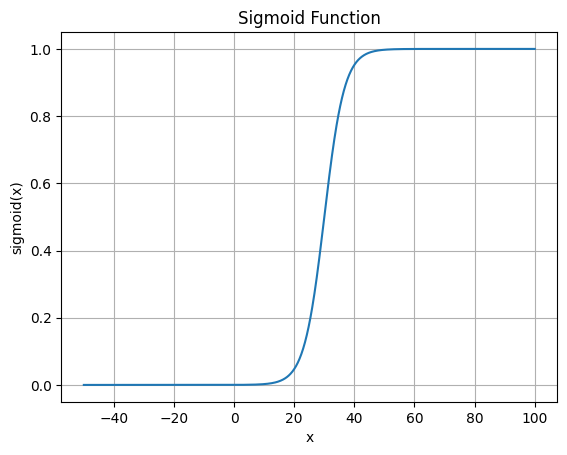

In [206]:
# 下面的代码主要是用于显示攻击期望归一化函数曲线


import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x, shift=30, scale=0.2):
    return 1 / (1 + np.exp(-(x - shift) * scale))

# 生成输入数据
x = np.linspace(-50, 100, 1000)
shift = 30
scale = 0.2

# 计算sigmoid函数的值
y = sigmoid(x, shift, scale)

# 绘制曲线图
plt.plot(x, y)
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.grid(True)
plt.show()
